In [174]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline

segmentation = True

In [175]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [176]:
data = pd.read_csv('WolliesX_DataScience_Test_data.csv')

# FEATURE ENGINEERING


### Binary classification
I assume that a loan, housing and default equal to 'unknown' is equivalent to 'no'. For simplicity, I also assume that a poutcome equal to 'nonexistent' is equal to 'failure'.

In [177]:
data.y.replace(('yes', 'no'), (1, 0), inplace=True)
data.contact.replace(('cellular', 'telephone'), (1, 0), inplace=True)
data.loan.replace(('yes', 'unknown', 'no'), (1, 0, 0), inplace=True)
data.housing.replace(('yes', 'unknown', 'no'), (1, 0, 0), inplace=True)
data.default.replace(('yes', 'unknown', 'no'), (1, 0, 0), inplace=True)
data.poutcome.replace(('success', 'nonexistent', 'failure'), (1, 0, 0), inplace=True)


### Middel school
I regroup the "basic" education labels to a single label called "middle.school".

In [178]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    data.loc[data['education'] == i, 'education'] = "middle.school"
    


### Unknown values
I infer the unknown entries in jobs and education. For example, all clients older than 60 are likely retired. Very young clients have not finished university yet.

In [179]:
data.loc[(data.job == 'unknown') & (data.age > 65), 'job'] = 'retired'
data.loc[(data.education == 'unknown') & (data.age < 18), 'education'] = 'middle.school'
data.loc[(data.education == 'unknown') & (data.age < 22), 'education'] = 'high.school'


### Segmentation
Segmentation of numerical features. 

In [180]:
if segmentation == True:
    #previous
    data.loc[data['previous'] == 0, 'previous'] = 0
    data.loc[(data['previous'] > 0) , 'previous'] = 1

    #age
    data.loc[(data['age'] > 10) & (data['age'] <= 30), 'age'] = 0
    data.loc[(data['age'] > 30) & (data['age'] <= 45)  , 'age'] = 1
    data.loc[(data['age'] > 45) & (data['age'] <= 60)  , 'age'] = 2
    data.loc[data['age']  > 60, 'age'] = 3
    
    #cons.conf.idx
    data.loc[(data['cons.conf.idx'] < -45), 'cons.conf.idx'] = 0
    data.loc[(data['cons.conf.idx'] > -45) & (data['cons.conf.idx'] <= -37)  , 'cons.conf.idx'] = 1
    data.loc[(data['cons.conf.idx']  > -37) & (data['cons.conf.idx'] <= -1)  , 'cons.conf.idx'] = 2

    #cons.price.idx
    data.loc[(data['cons.price.idx'] > 10) & (data['cons.price.idx'] <= 93.1), 'cons.price.idx'] = 0
    data.loc[(data['cons.price.idx'] > 93.1) & (data['cons.price.idx'] <= 93.8)  , 'cons.price.idx'] = 1
    data.loc[(data['cons.price.idx'] > 93.8) , 'cons.price.idx'] = 2



### Control and Treatment samples
Divide the datasets in two samples. <br />
1) Control sample (C): clients that have not participated in the marketing campain.<br />
2) Treatment sample (T) : clients that have participated in the marketing campain.<br />

In [181]:
f = data.campaign == 1
data_C = data[~f] #control sample
data_T = data[f] #treatment sample


### Relevant features
From T, I drop the following features:<br />
"campaign": already used to devide the samples.<br />
"duration": data leackage.<br />
"day_of_week": irrelevant.<br />

From C, I also drop "month" and "duration" because whese clients have not participated in the campaign.

In [182]:
data_T = data_T.drop(['campaign','duration','day_of_week'], axis=1) # I also drop "duration" (data leackage)
data_C = data_C.drop(['campaign','duration','contact','month','day_of_week'], axis=1)

print("Shape C: {}".format(data_C.shape))
print("Shape T: {}".format(data_T.shape))

Shape C: (23546, 12)
Shape T: (17642, 14)


### One-Hot encoding
Converting object type data into numeric types using One-Hot encoding method which is majorly used for XGBoost (for better accuracy).

In [183]:
data_all = pd.get_dummies(data, columns=['job','marital','education','month'])
data_T = pd.get_dummies(data_T, columns=['job','marital','education','month'])
data_C = pd.get_dummies(data_C, columns=['job','marital','education'])


### Features and target variable
Dividing features from the target column. 

In [184]:
data_all_y = pd.DataFrame(data_all['y'])
data_all_X = data_all.drop(['y'], axis=1)

data_T_y = pd.DataFrame(data_T['y'])
data_T_X = data_T.drop(['y'], axis=1)

data_C_y = pd.DataFrame(data_C['y'])
data_C_X = data_C.drop(['y'], axis=1)



### Is the sample well balanced?
I check if the sample in imbalanced. It is heavily imbalanced. That is an issue that I need to solve before I build my models.
To do so, I am oversampling with SMOTE or undersampling with Cluster Centroids.

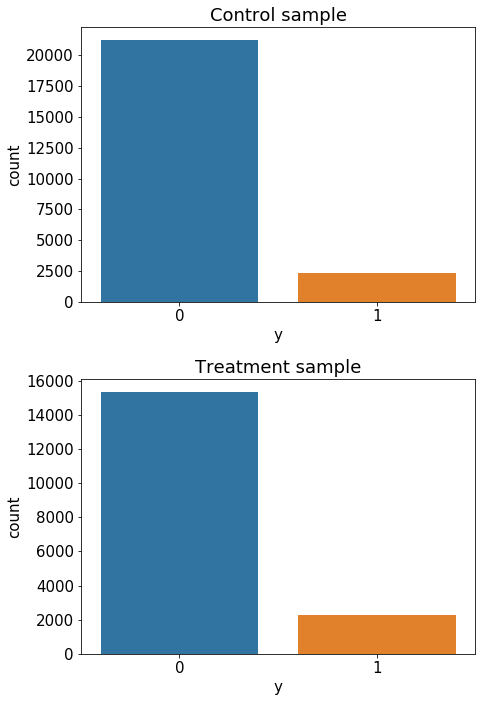

In [185]:
fig, ax = plt.subplots(2, figsize=(7,10))
plt.rcParams.update({'font.size': 15})
sns.countplot(data_C_y['y'], ax=ax[0])
sns.countplot(data_T_y['y'], ax=ax[1])
ax[0].set_title('Control sample')
ax[1].set_title('Treatment sample')
plt.tight_layout()

In [186]:
print(Counter(data_C_y.y))

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_C_resampled, y_C_resampled = pipeline.fit_resample(data_C_X, data_C_y)
X_T_resampled, y_T_resampled = pipeline.fit_resample(data_T_X, data_T_y)

print("Control sample. Original length: {}; Resampled length: {}".format(len(data_C_X), len(X_C_resampled)) )
print("Treatment sample. Original length: {}; Resampled length: {}".format(len(data_T_X), len(X_T_resampled)) )



Counter({0: 21206, 1: 2340})
Control sample. Original length: 23546; Resampled length: 12723
Treatment sample. Original length: 17642; Resampled length: 9204


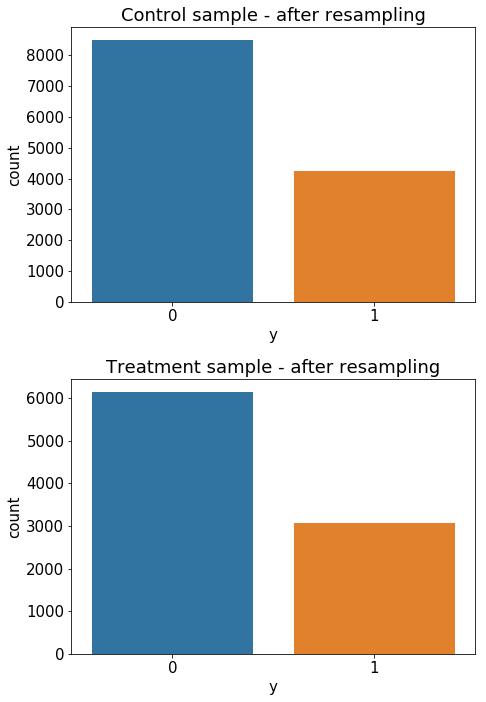

In [187]:
fig, ax = plt.subplots(2, figsize=(7,10))
plt.rcParams.update({'font.size': 15})
sns.countplot(y_C_resampled['y'], ax=ax[0])
sns.countplot(y_T_resampled['y'], ax=ax[1])
ax[0].set_title('Control sample - after resampling')
ax[1].set_title('Treatment sample - after resampling')
plt.tight_layout()

### Training and testing samples

In [188]:
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C_resampled, y_C_resampled, test_size=0.3, random_state=42, stratify = y_C_resampled)
X_T_train, X_T_test, y_T_train, y_T_test = train_test_split(X_T_resampled, y_T_resampled, test_size=0.3, random_state=42, stratify = y_T_resampled)


# MODELLING
The marketing team wants to roll-out the campaign to the entire customer population who are eligible for the product. For this they want my help on analysing the dataset to optimise output of their telemarketing campaign by maximise the conversion rate and reducing the cost (call centre cost and offer cost – interest rate discount).

In short, the questions that I want to answer are:<br />
- Is the marketing campaign working?
- Which are the most important features that should be used to predict who is going to buy the Credit Card?<br />
- Which is the population that can be persuaded by the campaign?<br />
- How should the bank approach these clients?<br />

I will tackle these questions using different approaches of increasing complexity.




## The very first question to ask: is the marketing campaign working?
In order to answer this question I calculate the Uplift value (QINI), defined as:

$\large QINI = \frac{TR}{T} - \frac{CR}{C}$ 

where

TR = Treatment Responders: Customers that received an offer and made the purchase<br />
CR = Control Responders: Customers that made the purchase without an offer<br />
T = Total cosumetrs in the treatment sample<br />
C = Total cosumetrs in the control sample<br />

In [232]:
qini = data_T.y.sum()/len(data_T) - data_C.y.sum()/len(data_C)
print("QINI: {}".format(qini))

QINI: 0.030990769124817213


A positive QINI means that the Bank is convincing clients to buy a product. The campaign is working.

This number can also works as a benchmark to measure how different strategies improve (or not) the campaign. 

## Two separate models for C and T samples

#### Aim
From my first approach in this analysis, I would like to answer the following questions:<br />
- Which are the most important features that affect the target variable?<br />
- Which are there features that are important for both C and T samples?<br />
- Which are the features that are important either for C or T?<br />
- How should the Bank approach its clients for this campaign?<br />

#### Method
The approach is very simple. I model the C and T samples separately in order to predict if a client is going to buy the Credit Card or not. 

#### Algorithm
The dataset contains many categorical variables. Algorithms based on Decision Trees work well on this kind of datasets. The dataset contains a small level of noise, so the XGBoost algorithm should perform better than other algorithm of this class. The problem of XGBoost is that it has many hyperparameters to tune, but the dataset is not huge so I can find the best parameters in a reasonable amount of time.

#### Code
Below I define the function that trains the model. The input parameters of the function are:<br />
- name: the name of the model;<br />
- X_train, y_train: the train sample;<br />
- X_test, y_test: the test sample that is used to validate the model;<br />
- train: if True a new model is trained. Otherwise the model is just validated.<br />
- find_estimators: if True the function finds the ideal number of estimators.<br />
- cv_folds: number of folds for the cross-validation;<br />
- early_stopping_rounds: tells when the algorithm should stop. I use this to find the best number of estimators;<br />
- param_grid: a grid of parameters that can be used for the best parameters search. If empty, the search is bypassed.

The function performs a cross validation with early stopping. This is done to find the best number of estimators. This helps against overfitting.<br />
Then, if param_grid is not empty, the function performs a grid search of the best parameters with cross validation. The evaluation metric is the accuracy because of my goals is important to be able to predict the clients that will buy/won't buy the Credit Card.<br />
Finally the model is trained on the training sample and validated on the testing sample.<br />
The very last step is to save the model.


In [190]:
def xgb_model(name, alg, X_train, y_train, X_test, y_test, train = True, find_estimators = True, cv_folds = 5, early_stopping_rounds = 20, param_grid = {}):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    
    if train:
        if find_estimators:
            print("Tuning n_estimators")
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, early_stopping_rounds=early_stopping_rounds)
            alg.set_params(n_estimators=cvresult.shape[0])
            print("          Best number estimators: {}".format(cvresult.shape[0]))
            xgb_param = alg.get_xgb_params()
        
        if param_grid:
            print("GridSearchCV")
        
            GSCV = GridSearchCV(estimator=alg, param_grid=param_grid, scoring='accuracy', n_jobs=4, cv=5, verbose=True)
            
            GSCV.fit(X_train, np.ravel(y_train))
            alg.set_params(**GSCV.best_params_)
            
            for param_name in sorted(GSCV.best_params_.keys()):
                print("    {}: {}".format(param_name, GSCV.best_params_[param_name]))
                


        print('Start Training')
        alg.fit(X_train, np.ravel(y_train), eval_metric='auc') 
    
    print("Start Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]
    
    print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
    print("AUC: {}".format(roc_auc_score(y_test, pred_proba)))
    print("F1 Score: {}".format(f1_score(y_test, predictions)))
    
    joblib.dump(alg, name+'.model')
    
    return alg


Here I set build the model. First, I select some important parameters for the XGB Classifier. I also use the param_grid to search the best parameters. In practice, to save time and have a better control on the process, initially I perform the Grid Search sequentially on 'max_depth', then on 'min_child_weight', followed by 'learning_rate', etc... 

I start with modelling the C sample, then I model the T sample.

In [219]:
xgb_in = XGBClassifier(
 eval_metric = 'auc',
 objective= 'binary:logistic',
 max_depth=2, #start from 2 and increase of 1
 min_child_weight=1, #start from 1 and increase of 1
 learning_rate =0.08, #the amount of "correction" we make at each step. Usually between 0.1 and 0.01
 subsample=0.9, #the fraction of rows taken to build the tree. Usually between 0.8 and 1.
 colsample_bytree=0.9, #the fraction of columns taken to build the tree. Usually between 0.8 and 1 if you have few columns.
 gamma=1, # Eirther 0, 1 or 5.
 reg_alpha = 0,
 reg_lambda = 1,
 n_estimators=1000, #large number that will be corrected by CV
 seed=27)

param_grid = {
# 'max_depth':[4,5,6],
#'min_child_weight':[1,2,3,4]
#'learning_rate': [0.1,0.08,0.05],
# 'subsample': [0.8,0.9,1.],
# 'colsample_bytree': [0.8,0.9,1],
# 'gamma': [0,1,5]
}

mod_C = xgb_model('control', xgb_in, X_C_train, y_C_train, X_C_test, y_C_test, train=True, find_estimators = True, cv_folds = 5, early_stopping_rounds = 20, param_grid=param_grid)


Tuning n_estimators
          Best number estimators: 537
Start Training
Start Predicting
Accuracy: 0.771548336389835
AUC: 0.7851827482670422
F1 Score: 0.5505154639175257


In [220]:
xgb_in = XGBClassifier(
 eval_metric = 'auc',
 objective= 'binary:logistic',
 max_depth=2, #start from 3 and increase of 1
 min_child_weight=1, #start from 1 and increase of 1
 learning_rate =0.08, #the amount of "correction" we make at each step. Usually between 0.1 and 0.01
 subsample=0.9, #the fraction of rows taken to build the tree. Usually between 0.8 and 1.
 colsample_bytree=0.9, #the fraction of columns taken to build the tree. Usually between 0.8 and 1 if you have few columns.
 gamma=1, # Eirther 0, 1 or 5.
 reg_alpha = 0,
 reg_lambda = 1,
 n_estimators=1000, #large number that will be corrected by CV
 seed=27)

param_grid = {
# 'max_depth':[8,9,10],
# 'min_child_weight':[1,2,3,4],
#'learning_rate': [0.1,0.08,0.05],
# 'subsample': [0.8,0.9,1.],
# 'colsample_bytree': [0.8,0.9,1],
# 'gamma': [0,1,5]
}

mod_T = xgb_model('treatment', xgb_in, X_T_train, y_T_train, X_T_test, y_T_test, train=True, find_estimators = True, cv_folds = 5, early_stopping_rounds = 20, param_grid=param_grid)


Tuning n_estimators
          Best number estimators: 561
Start Training
Start Predicting
Accuracy: 0.7910934105720493
AUC: 0.8171289620367534
F1 Score: 0.6422814631122133


I load the models

In [221]:
mod_C = joblib.load('control.model')
mod_T = joblib.load('treatment.model')



### Feature importances - Control sample


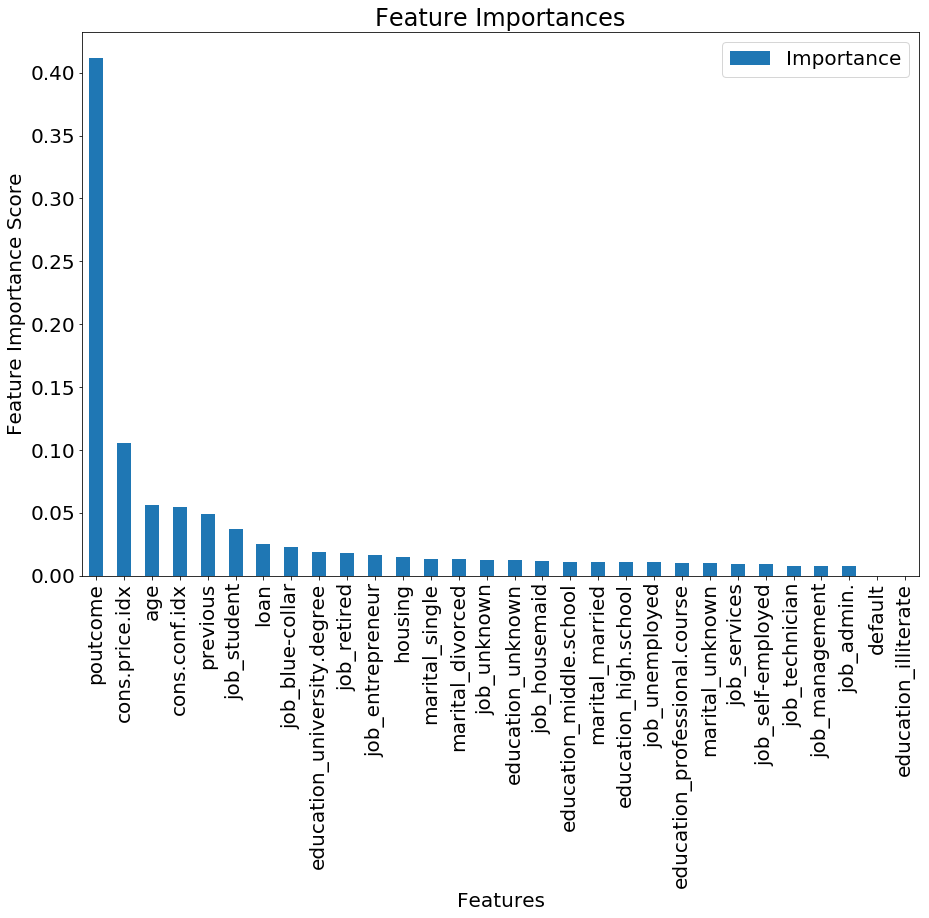

                         Features  Importance
5                        poutcome    0.411748
6                  cons.price.idx    0.105683
0                             age    0.056059
7                   cons.conf.idx    0.054989
4                        previous    0.049163
16                    job_student    0.037065
3                            loan    0.024868
9                 job_blue-collar    0.022862
28    education_university.degree    0.018572
13                    job_retired    0.018257
10               job_entrepreneur    0.016408
2                         housing    0.014505
22                 marital_single    0.013267
20               marital_divorced    0.013053
19                    job_unknown    0.012764
29              education_unknown    0.012731
11                  job_housemaid    0.011772
26        education_middle.school    0.011099
21                marital_married    0.011010
24          education_high.school    0.010978
18                 job_unemployed 

In [222]:
feat_imp = mod_C.feature_importances_
feat = X_C_train.columns.tolist()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances', figsize=(15, 10))
plt.ylabel('Feature Importance Score')
plt.show()
print(res_df)
#print(res_df["Features"].tolist())


### Feature importances - Treatment sample
What I am learning from the feature importance analysis:<br /> 
- poutcome is by far the most important feature in both the sample. It indicates that it is important to establish bonds with clients.<br /> 
- Other features, such as age, price index and previous contacts, are also very important in both the samples.<br /> 
- Focussing on the treatment sample, we learn how the Bank should approach its clients. The contact should be done via cellular. May should be avoided. March, September and October are the most promising months.<br /> 
- Jobs are not really important overall.


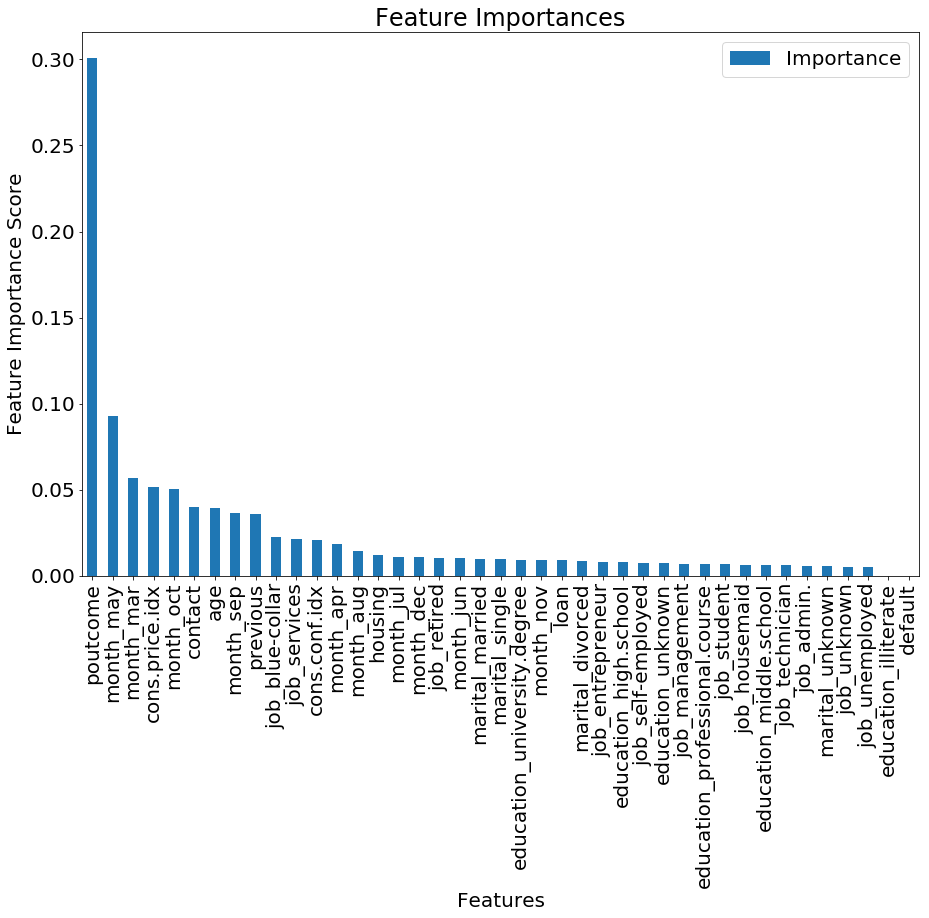

                         Features  Importance
6                        poutcome    0.300845
37                      month_may    0.092660
36                      month_mar    0.056788
7                  cons.price.idx    0.051704
39                      month_oct    0.050198
4                         contact    0.039893
0                             age    0.039207
40                      month_sep    0.036152
5                        previous    0.035677
10                job_blue-collar    0.022219
16                   job_services    0.021584
8                   cons.conf.idx    0.020454
31                      month_apr    0.018561
32                      month_aug    0.014556
2                         housing    0.012064
34                      month_jul    0.010837
33                      month_dec    0.010795
14                    job_retired    0.010169
35                      month_jun    0.010120
22                marital_married    0.009906
23                 marital_single 

In [224]:
feat_imp = mod_T.feature_importances_
feat = X_T_train.columns.tolist()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances', figsize=(15, 10))
plt.ylabel('Feature Importance Score')
plt.show()
print(res_df)
#print(res_df["Features"].tolist())


### Confusion matrix

My initial idea was to use the model trained on the Control sample to predict the outcome of the campaign in the Treatment sample. The False Negatives would have given me the sample of clients that have been persuaded by the campaign. Unfortunately, through a careful inspection of the confusion matrixes plotted below, I arrived to the conclusion that this idea would not work well.

In fact, if I test on T the model trained on C (right matrix), the fraction of False Negatives is even lower than the fraction of False Negatives that I obtain if the model is trained and tested on C (left matrix). To be honest, I do not clearly understand why (I should think more about it), but it is evident that my initial idea was wrong. Thus, I am going to proceed with a different approach. 

Text(0.5, 1.0, 'Model trained on C, tested on T')

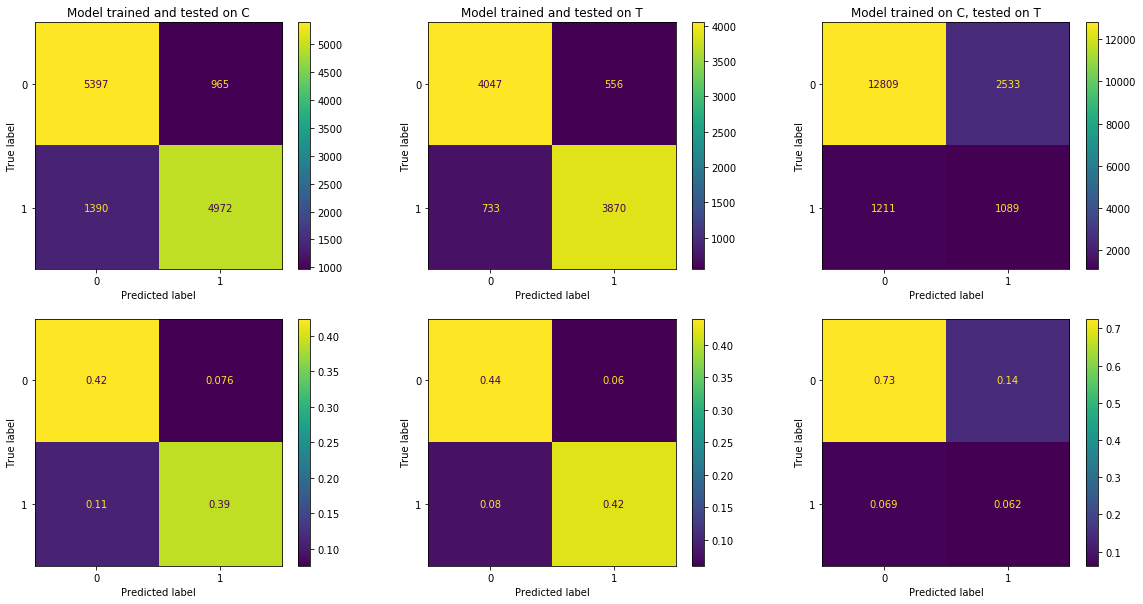

In [199]:
cols_to_drop = ['month_oct', 'month_dec', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 'month_apr', 
                'month_sep', 'month_may', 'contact', 'month_nov']

data_T_X_C_features = data_T_X.drop(cols_to_drop, axis=1)
data_T_y_C_features = data_T_y


fig, ax = plt.subplots(2,3, figsize=(20,10))

plot_confusion_matrix(mod_C, X_C_test, y_C_test, ax=ax[0,0])
plot_confusion_matrix(mod_C, X_C_test, y_C_test, normalize='all', ax=ax[1,0])
plot_confusion_matrix(mod_T, X_T_test, y_T_test, ax=ax[0,1])
plot_confusion_matrix(mod_T, X_T_test, y_T_test, normalize='all', ax=ax[1,1])

plot_confusion_matrix(mod_C, data_T_X_C_features, data_T_y_C_features, ax=ax[0,2])
plot_confusion_matrix(mod_C, data_T_X_C_features, data_T_y_C_features, normalize='all', ax=ax[1,2])

ax[0,0].set_title("Model trained and tested on C")
ax[0,1].set_title("Model trained and tested on T")
ax[0,2].set_title("Model trained on C, tested on T")



## Uplift modelling

#### Aim
I want to evaluate the effect that the marketing campaign would have on the control sample. 

Obviously, a client cannot be part of both the Control and Treatment samples. However, I can ideally divide the sample of all my clients in four categories:<br />
- Sleeping dogs. Clients that will buy only if not targeted by the campaign;<br />
- Lost causes. Clients that will not buy in any case;<br />
- Sure thing. Clients that will buy in any case;<br />
- Persuadeables. Clients that will buy only if targeted by the campaign.<br />

Considering that clients receive an offer if they are targeted by the campaign, I can assume that the "sleeping dogs" are very few. The Bank does not want to approach "lost causes" and "sure thing", because that would be a waste of money (call centre cost and offer cost) and human resources. Instead, it is very important that the Bank targets the "Persuadeables". Thus, untimately I want to answer the question: who are the clients that I can persuade?

#### Method
I use a class trasformation method. I use the information on the group (control/treatement) and on the purchase (buy/not buy the credit card) to define another target feature.

Accordingly to the methodology developed by Athey and Imbens (2015), the new target feature is defined as:

$\large z = y \times \frac{campaign - e}{e \times (1-e)}$

where y is the original target feature, campaign is 1 if the treatment sample and 0 otherwise, and e is the probability of being assigned to treatment group given its characteristics. The variable z is called "uplift score". 

Assuming that the treatment sample has been chosen randomly, I define:

$\large e = T/(T+C)$

For example, if e=0.5, then a purchase in the treatment group is evaluated to 2, purchase in control group is evaluated as -2 and no purchase in treatment and control group is evaluated to 0. Therefore, clients with z>0 are a mixture of "Persuadeables" and "Sure thing". Clients with z<0 are a mixture of "Sleeping dogs" and "Sure things". 

The method consists in training a model to predict the uplift score. Then, the predicted uplift score can be used to isolate "Persuadeables" and "Sleeping dogs" from the sample.



Text(0, 0.5, 'Number')

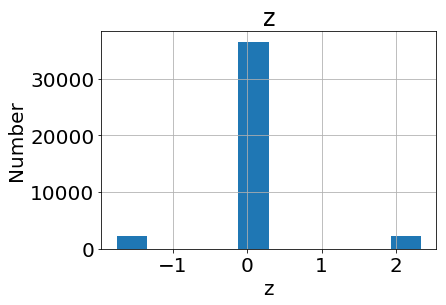

In [227]:
y_obs = data.y
prob_T = data.campaign.sum()/len(data)
z = y_obs * (data.campaign - prob_T)/(prob_T * (1 - prob_T))
data_ul_z = pd.DataFrame({'z': z})
data_ul_z.hist('z')
plt.xlabel("z")
plt.ylabel("Number")

I drop all the columns that are related only to the treatment group and I perform the One-Hot_encoding for the other object features. Then I split the sample in training and testing sets.

In [44]:
data_ul = data.drop(['campaign','duration','contact','month','day_of_week'], axis=1)
data_ul_X = pd.get_dummies(data_ul, columns=['job','marital','education'])
X_ul_train_with_y, X_ul_test_with_y, z_ul_train, z_ul_test = train_test_split(data_ul_X, data_ul_z, test_size=0.3, random_state=42)
X_ul_train = X_ul_train_with_y.drop(['y'], axis=1) 
X_ul_test = X_ul_test_with_y.drop(['y'], axis=1) 


#### Algorithm
Following the same reasoning as above, I choose a XGBoost algorithm. The only difference is that this time I will use a regressor.

#### Code
The function that trains the model is very similar to the one that I have used before. The main difference, apart the fact that I am using a regressor, is that I am evaluating the model over the MSE.



In [45]:
def xgb_model_reg(name, alg, X_train, y_train, X_test, y_test, train = True, find_estimators = True, cv_folds = 5, early_stopping_rounds = 20, param_grid = {}):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    
    if train:
        if find_estimators:
            print("Tuning n_estimators")
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, early_stopping_rounds=early_stopping_rounds)
            alg.set_params(n_estimators=cvresult.shape[0])
            print("          Best number estimators: {}".format(cvresult.shape[0]))
            xgb_param = alg.get_xgb_params()
        
        if param_grid:
            print("GridSearchCV")
        
            GSCV = GridSearchCV(estimator=alg, param_grid=param_grid, n_jobs=4, cv=5, verbose=True)
            
            GSCV.fit(X_train, np.ravel(y_train))
            alg.set_params(**GSCV.best_params_)
            
            for param_name in sorted(GSCV.best_params_.keys()):
                print("    {}: {}".format(param_name, GSCV.best_params_[param_name]))
                


        print('Start Training')
        alg.fit(X_train, np.ravel(y_train), eval_metric='auc') 
    
    print("Start Predicting")
    predictions = alg.predict(X_test)
    
    print("mean_squared_error: {}".format(mean_squared_error(y_test, predictions)))
    
    joblib.dump(alg, name+'.model')
    
    return alg


In [46]:
xgb_in = XGBRegressor(
 eval_metric = 'rmse',
 objective = 'reg:squarederror',
 max_depth=1, #start from 3 and increase of 1
 min_child_weight=1, #start from 1 and increase of 1
 learning_rate =0.1, #the amount of "correction" we make at each step. Usually between 0.1 and 0.01
 subsample=0.9, #the fraction of rows taken to build the tree. Usually between 0.8 and 1.
 colsample_bytree=0.9, #the fraction of columns taken to build the tree. Usually between 0.8 and 1 if you have few columns.
 gamma=0, #regularization parameters (Ridge). Eirther 0, 1 or 5.
 reg_alpha = 0,
 reg_lambda = 1,
 n_estimators=1000, #large number that will be corrected by CV
 seed=27)

param_grid = {
# 'max_depth':[1,2,3,4]
# 'min_child_weight':[1,2,3,4,5,6]
#'learning_rate': [0.1,0.08,0.05]
# 'subsample': [0.8,0.9,1.]
# 'colsample_bytree': [0.7,0.8,0.9,1],
# 'gamma': [0,1,5]
}

mod_UL = xgb_model_reg('uplifting', xgb_in, X_ul_train, z_ul_train, X_ul_test, z_ul_test, train=True, find_estimators = True, cv_folds = 5, early_stopping_rounds = 20, param_grid=param_grid)


Tuning n_estimators
          Best number estimators: 58
Start Training
Start Predicting
mean_squared_error: 0.47054646589990873


The clients with high predicted z are those that have been persuaded by the campaign. I can arbitrarily define as Persuadeables all the clients with a predicted score >0.15.

The sleeping dogs should have negative scores, thus there are no sleeping dogs among my clients. This makes sense because I am offering deals.



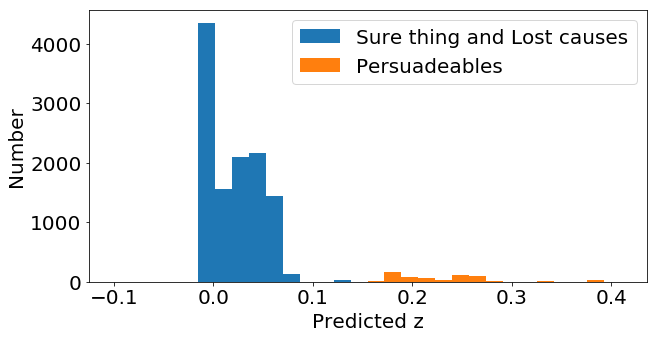

In [228]:
mod_UL = joblib.load('uplifting.model')
predicted_scores = mod_UL.predict(X_ul_test)

plt.figure(figsize=(10,5))
ax = plt.hist(predicted_scores, bins = 30, range=[-0.1,0.41], label = "Sure thing and Lost causes")
plt.xlabel("Predicted z")
plt.ylabel("Number")

persuaded = np.zeros(len(X_ul_test))
persuaded[predicted_scores > 0.15] = 1
ax = plt.hist(predicted_scores[predicted_scores > 0.15], bins = 30, range=[-0.1,0.41], label = "Persuadeables")
plt.legend()


### Feature importances
The most important features are "poutcome", "cons.price.idx", and "age". 

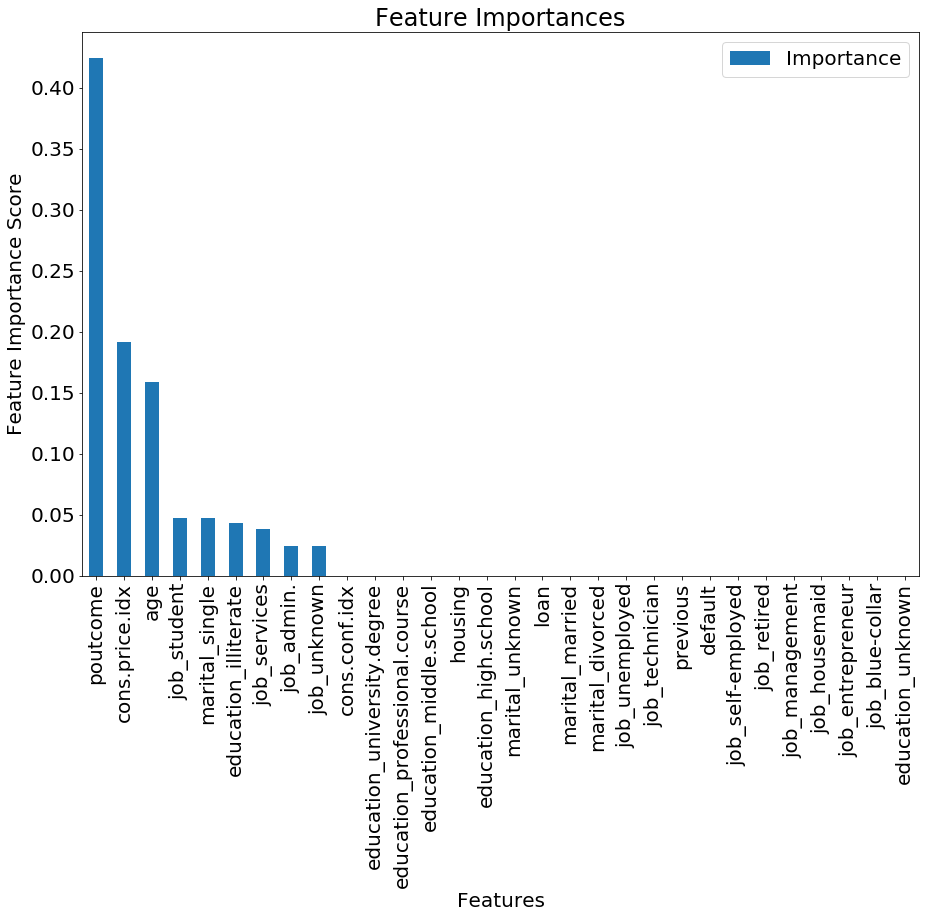

                         Features  Importance
5                        poutcome    0.424439
6                  cons.price.idx    0.191811
0                             age    0.159016
16                    job_student    0.047514
22                 marital_single    0.047356
25           education_illiterate    0.043067
15                   job_services    0.038345
8                      job_admin.    0.024370
19                    job_unknown    0.024083
7                   cons.conf.idx    0.000000
28    education_university.degree    0.000000
27  education_professional.course    0.000000
26        education_middle.school    0.000000
2                         housing    0.000000
24          education_high.school    0.000000
23                marital_unknown    0.000000
3                            loan    0.000000
21                marital_married    0.000000
20               marital_divorced    0.000000
18                 job_unemployed    0.000000
17                 job_technician 

In [230]:
feat_imp = mod_UL.feature_importances_
feat = X_ul_train.columns.tolist()
res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances', figsize=(15, 10))
plt.ylabel('Feature Importance Score')
plt.show()
print(res_df)


All the clients with poutcome = 1 have been persuaded. These clients must be the targets of the campaign.

In [49]:
norm = pd.crosstab(X_ul_test['poutcome'], persuaded, normalize='index')
tot = pd.crosstab(X_ul_test['poutcome'], persuaded)
display_side_by_side(norm,tot)

col_0,0.0,1.0
poutcome,,
0,0.984569,0.015431
1,0.000000,1.000000
col_0,0.0,1.0
poutcome,,
0,11740,184
1,0,433


The 87% of the old (age >60 yr) clients have been persuaded. The campaign has to targets also these clients.

In [50]:
norm = pd.crosstab(X_ul_test['age'],persuaded, normalize='index')
tot = pd.crosstab(X_ul_test['age'], persuaded)
display_side_by_side(norm,tot)

    #age
    #data.loc[(data['age'] > 10) & (data['age'] <= 30), 'age'] = 0
    #data.loc[(data['age'] > 30) & (data['age'] <= 45)  , 'age'] = 1
    #data.loc[(data['age'] > 45) & (data['age'] <= 60)  , 'age'] = 2
    #data.loc[data['age']  > 60, 'age'] = 3


col_0,0.0,1.0
age,,
0,0.949068,0.050932
1,0.973441,0.026559
2,0.970909,0.029091
3,0.130112,0.869888
col_0,0.0,1.0
age,,
0,2087,112
1,6414,175
2,3204,96


A 11% of clients with low price index have been persuaded. It would be a good idea to include these clients as well among the targets.

In [51]:
norm = pd.crosstab(X_ul_test['cons.price.idx'], persuaded, normalize='index')
tot = pd.crosstab(X_ul_test['cons.price.idx'], persuaded)
display_side_by_side(norm,tot)


col_0,0.0,1.0
cons.price.idx,,
0.0,0.885071,0.114929
1.0,0.977363,0.022637
2.0,0.974472,0.025528
col_0,0.0,1.0
cons.price.idx,,
0.0,3065,398
1.0,2720,63
2.0,5955,156


I can use this model in two other ways.

First, I can draw the Uplift Curve and use it to perform quantitative comparison with future marketing campaigns. The larger is the area under the curve and the larger is the effect of the campaign.

Second, I can use my model to predict the uplift score of all my other client and give a ranking on who are the clients that I should call first.

In [90]:
uplift = pd.DataFrame({'pred_z': predicted_scores, 'y': X_ul_test_with_y.y})
uplift = uplift.sort_values(by='pred_z', ascending=False)
uplift['cumulative_sum'] = uplift.y.cumsum()
uplift = uplift.reset_index(drop=True)
uplift['id'] = uplift.index
uplift

,pred_z,y,cumulative_sum,id
0,0.398496,1,1,0
1,0.398496,0,1,1
2,0.388129,1,2,2
3,0.386644,1,3,3
4,0.386644,0,3,4
...,...,...,...,...
12352,-0.009434,0,1389,12352
12353,-0.009434,0,1389,12353
12354,-0.009434,0,1389,12354
12355,-0.009434,0,1389,12355


Text(0.5, 1.0, 'Uplift curve - cumulative gains chart')

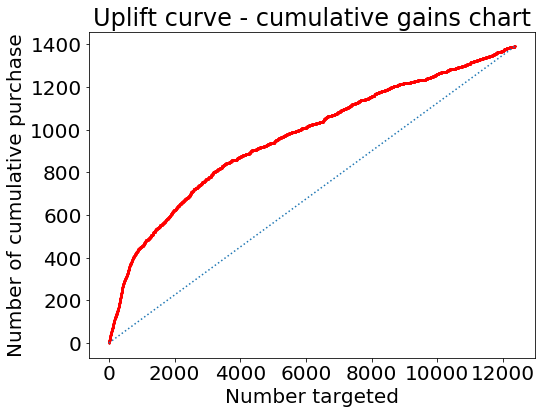

In [231]:
plt.figure(figsize=(8,6))
plt.scatter(uplift.id, uplift.cumulative_sum, s=1, c='red')
plt.plot([0,max(uplift.id)],[0,max(uplift.cumulative_sum)], ':')
plt.xlabel("Number targeted")
plt.ylabel("Number of cumulative purchase")
plt.title("Uplift curve - cumulative gains chart")

## Final recommendations

- It is very important to offer deals to clients that can be persuaded, such as costumers older than 60 yr, those with a low price index and those that have acccepted offers in the past.
- The uplift model can be used to identify the high-priority targets for this campaign. Call them first!
- The clients should be contacted via cellular.
- The most promising months are March, September, and December. May should be avoided.
- After have followed these recommendations, the uplift curve should be drown again to verify that the campaign has improved the results.